In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import scipy
from functools import partial
from jax.test_util import check_grads
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin
from scipy.optimize import minimize
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearings_utils import make_parameters
from bearing_data import get_data, inverse_bearings


In [2]:
linearization_method = extended

s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

r_true = 0.05

T = 50
_, true_states, ys = get_data(x0, dt, r_true, T, s1, s2)
Q, _, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
# chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)

initial_states =  MVNStandard(jnp.repeat(jnp.array([[0.4, 0.15, 0.9, 1, 1]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[0.4, 0.15, 0.9, 1, 1]]),T + 1, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))


# true_states = true_states.astype(np.float64)

2022-04-25 16:54:59.512669: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 16:55:00.234803: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 16:55:00.237442: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

In [3]:
#standard
@jax.jit
def get_ell_std(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))  
    
    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               linearization_method, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_std = jax.jit(jax.value_and_grad(get_ell_std))

In [4]:
gpu_grad_ell_std = jax.jit(grad_ell_std, backend="gpu")



In [5]:
def wrap_func_std(r):
    loss, grad_val = gpu_grad_ell_std(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
r0 = np.array([10.])
minimize(wrap_func_std, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)])


2022-04-25 16:55:23.971353: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 16:55:23.971558: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 16:55:23.987240: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 16:55:24.231427: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 16:55:24.246506: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 16:55:24.247018: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

      fun: array(-106.29413134)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.84207568e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 7
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([20.26653977])

In [6]:
#square-root
@jax.jit
def get_ell_sqrt(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    observation_model_sqrt = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R)) 
    
    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, observation_model_sqrt,
                                               linearization_method, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_sqrt = jax.jit(jax.value_and_grad(get_ell_sqrt))


In [7]:
gpu_grad_ell_sqrt = jax.jit(grad_ell_sqrt, backend="gpu")

In [8]:
def wrap_func_sqrt(r):
    loss, grad_val = gpu_grad_ell_sqrt(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
r0 = np.array([10.])
minimize(wrap_func_sqrt, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)])


2022-04-25 17:00:23.177932: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:00:23.383959: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:00:23.432853: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:00:24.419607: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:00:24.453285: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:00:24.476907: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:00:25.185736: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:00:25.274641: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


      fun: array(-106.29412987)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.84972136e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 7
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([20.26653935])

In [10]:
# jnp.savez("pe_ell_std_extended_T50",
#           ell_std_extended_T50 = np.array(jax.vmap(lambda r: get_ell_std(r))(np.linspace(10, 50)[:, None])),
#           theta_std = 1 / minimize(wrap_func_std, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x)

# jnp.savez("pe_ell_sqrt_extended_T50",
#           ell_sqrt_extended_T50 = np.array(jax.vmap(lambda r: get_ell_sqrt(r))(np.linspace(10, 50)[:, None])),
#           theta_sqrt = 1 / minimize(wrap_func_sqrt, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x)

jnp.savez("pe_ell_std_extended_T50_par",
          ell_std_extended_T50_par = np.array(jax.vmap(lambda r: get_ell_std(r))(np.linspace(10, 50)[:, None])),
          grad_ell_std_extended_T50_par = np.array(jax.vmap(lambda r: grad_ell_std(r))(np.linspace(10, 50)[:, None])[1]),
          theta_par_std = 1 / minimize(wrap_func_std, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x)

jnp.savez("pe_ell_sqrt_extended_T50_par",
          ell_sqrt_extended_T50_par = np.array(jax.vmap(lambda r: get_ell_sqrt(r))(np.linspace(10, 50)[:, None])),
          grad_ell_sqrt_extended_T50_par = np.array(jax.vmap(lambda r: grad_ell_sqrt(r))(np.linspace(10, 50)[:, None])[1]),
          theta_par_sqrt = 1 / minimize(wrap_func_sqrt, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x)



2022-04-25 17:05:21.349620: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:21.351457: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:21.355151: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:05:21.557152: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:21.568407: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:21.590190: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:05:46.869956: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:46.878678: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:46.879118: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:05:47.082716: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:47.095328: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:05:47.119017: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:07:16.281554: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:07:16.283157: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:07:16.295566: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:12:25.201058: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:12:25.237210: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:12:25.243790: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:12:25.610792: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:12:25.612117: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:12:25.612634: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2022-04-25 17:12:26.438302: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-04-25 17:12:26.514398: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [11]:
# with np.load("pe_ell_std_extended_T50.npz") as loaded:
#     ell_std_extended_T50 = loaded["ell_std_extended_T50"]
#     theta_std = loaded["theta_std"]
    
# with np.load("pe_ell_sqrt_extended_T50.npz") as loaded:
#     ell_sqrt_extended_T50 = loaded["ell_sqrt_extended_T50"]
#     theta_sqrt = loaded["theta_sqrt"]

with np.load("pe_ell_std_extended_T50_par.npz") as loaded:
    ell_std_extended_T50_par = loaded["ell_std_extended_T50_par"]
    grad_ell_std_extended_T50_par = loaded["grad_ell_std_extended_T50_par"]
    theta_par_std = loaded["theta_par_std"]
    
with np.load("pe_ell_sqrt_extended_T50_par.npz") as loaded:
    ell_sqrt_extended_T50_par = loaded["ell_sqrt_extended_T50_par"]
    grad_ell_sqrt_extended_T50_par = loaded["grad_ell_sqrt_extended_T50_par"]
    theta_par_sqrt = loaded["theta_par_sqrt"]

# with np.load("pe_ell_std_cubature_T50.npz") as loaded:§
#     ell_std_cubature_T50 = loaded["ell_std_cubature_T50"]
    
# with np.load("pe_ell_sqrt_cubature_T50.npz") as loaded:
#     ell_sqrt_cubature_T50 = loaded["ell_sqrt_cubature_T50"]

# plt.plot(np.linspace(10, 50), ell_std_extended_T50)



# plt.plot(np.linspace(10, 50), ell_sqrt_extended_T50)

[0.04934241]
[0.04934242]


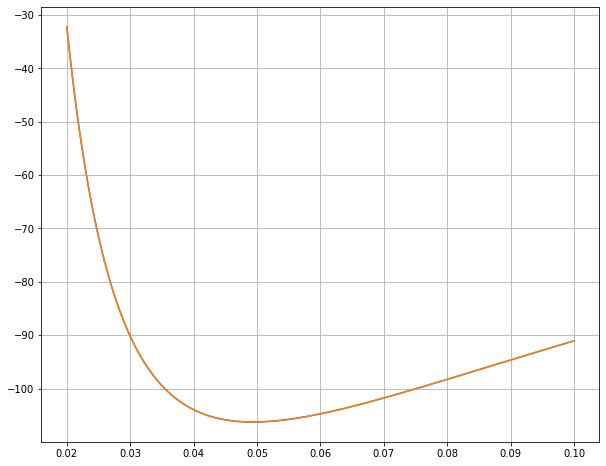

In [12]:
plt.figure(figsize=(10,8))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_std_extended_T50))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_sqrt_extended_T50))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_std_extended_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_sqrt_extended_T50_par))
plt.grid()

# print(theta_std)
# print(theta_sqrt)
print(theta_par_std)
print(theta_par_sqrt)



In [ ]:
plt.figure(figsize=(10,8))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_std_extended_T50))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_sqrt_extended_T50))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_extended_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_extended_T50_par))
plt.grid()

In [ ]:
plt.plot(np.linspace(11, 14), 
         np.array(jax.vmap(lambda r: grad_ell_sqrt(r))(np.linspace(11, 14)[:, None])[1]))